In [1]:
import sys
sys.path.insert(0, "C:/Users/easht/Documents/GitHub/group-project-team4/Code/neural_network")
from Recommender_Model import Recommender_Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import random
import statsmodels.api as sm

In [2]:
#Read data from csv, re-code movie and user ids and find rating mean
df = pd.read_csv("C:/Users/easht/Documents/CS 673/Movie Database/merged.csv")
df.userId = pd.Categorical(df.userId)
df["new_user_id"] = df.userId.cat.codes
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes
mRatings = df['rating'].mean()
stdRatings = df['rating'].std()

In [3]:
# Calcualte mean and N_ratings for each movie and merge onto main dataframe
movie_stats = pd.pivot_table(df, values = "rating", index = ["title","new_movie_id"], 
                aggfunc=[np.mean, np.count_nonzero]).reset_index()
movie_stats.columns = ['title','new_movie_id','mean_rating','n_ratings']
df = df.merge(movie_stats)

In [4]:
#split data into training (80% of users) and testing (20% of users) sets
user_ids = np.array(list(set(df['new_user_id'].values)))
user_ids = shuffle(user_ids)
# 80% training, 18% testing no hiding, 2% testing with hiding
brk1 = int(0.75 * len(user_ids))
brk2 = int(0.98 * len(user_ids))
user_train = user_ids[:brk1]
user_test = user_ids[brk1:]
user_test_no_hide = user_ids [brk1:brk2]
user_test_hide = user_ids [brk2:]
df_train = df.loc[df['new_user_id'].isin(user_train)]
df_test = df.loc[df['new_user_id'].isin(user_test)]
df_test_no_hide = df.loc[df['new_user_id'].isin(user_test_no_hide)]
df_test_hide = df.loc[df['new_user_id'].isin(user_test_hide)]

In [5]:
print("Train: " + str(len(user_train)) + " users, and " + str(len(df_train)) + " ratings")
print("Test (all): " + str(len(user_test)) + " users, and " + str(len(df_test)) + " ratings")
print("Test (no hide): " + str(len(user_test_no_hide)) + " users, and " + str(len(df_test_no_hide)) + " ratings")
print("Test (hide): " + str(len(user_test_hide)) + " users, and " + str(len(df_test_hide)) + " ratings")

Train: 103869 users, and 14963766 ratings
Test (all): 34624 users, and 5036497 ratings
Test (no hide): 31854 users, and 4623870 ratings
Test (hide): 2770 users, and 412627 ratings


In [6]:
THRESHOLD_FOR_TOP_30 = 41106
df_test_hide_hidden = df_test_hide.loc[df_test_hide['n_ratings'] < THRESHOLD_FOR_TOP_30 ]
df_test_hide_not_hidden = df_test_hide.loc[df_test_hide['n_ratings'] >= THRESHOLD_FOR_TOP_30 ]

In [7]:
#test that test and train lists are split correctly and test is correctly split into hide and not
print("total size " + str(len(df)))
print("train size " + str(len(df_train)))
print("test size " + str(len(df_test)))
print("test hide users: #hidden ratings " + str(len(df_test_hide_hidden)))
print("test hide users: #non-hidden ratings " + str(len(df_test_hide_not_hidden)))

assert len(df_train) + len(df_test) == len(df), "list not split correctly"
assert len(df_test_hide_hidden) + len(df_test_hide_not_hidden) == len(df_test_hide), "list not split correctly"
assert df_test_hide_hidden['n_ratings'].max() < THRESHOLD_FOR_TOP_30, "list not split correctly"
assert df_test_hide_not_hidden['n_ratings'].min() >= THRESHOLD_FOR_TOP_30, "list not split correctly"

total size 20000263
train size 14963766
test size 5036497
test hide users: #hidden ratings 383397
test hide users: #non-hidden ratings 29230


In [8]:
df_test_no_hide_users_and_non_hidden_ratings = df_test_no_hide.append(df_test_hide_not_hidden)
print(len(df_test_no_hide))
print(len(df_test_hide_not_hidden))
print(len(df_test_no_hide_users_and_non_hidden_ratings))

4623870
29230
4653100


In [9]:
user_train = df_train["new_user_id"].values
movie_train = df_train["new_movie_id"].values
ratings_train = df_train["rating"].values
user_test = df_test_no_hide_users_and_non_hidden_ratings["new_user_id"].values
movie_test = df_test_no_hide_users_and_non_hidden_ratings["new_movie_id"].values
ratings_test = df_test_no_hide_users_and_non_hidden_ratings["rating"].values
ratings_train -= mRatings
ratings_test -= mRatings


In [10]:
# Get number of users and number of movies
uNum = len(set(user_ids))
mNum = len(set(df['new_movie_id']))
# Set embedding dimension
K = 50

#Rui's code to initialize the model
model = Recommender_Model(K, uNum, mNum)
model.compile(optimizer=SGD(learning_rate=1e-2, momentum=3e-1),
                  loss="mse")


In [11]:
#set model parameters

# Create a scheduler to change the learning rate
def schedule(epoch, lr):
    if epoch >= 20:
        return 1e-3
    return 1e-2
    
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [12]:
# unit test to check that the test arrays are all still equal to each other in length after being split, edited, and rejoined
print(len(user_test))
print(len(movie_test))
print(len(ratings_test))
assert ((len(user_test) == len(movie_test)) and (len(user_test) == len(ratings_test))), 'test arrays are not equal'

4653100
4653100
4653100


In [13]:
r = model.fit([user_train, movie_train], ratings_train, batch_size=1024, epochs=25,
                  validation_data=([user_test, movie_test], ratings_test), callbacks=[callback, scheduler])

Epoch 1/25
14614/14614 [==============================] - 1074s 73ms/step - loss: 0.8262 - val_loss: 0.8997 - lr: 0.0100
Epoch 2/25
14614/14614 [==============================] - 1079s 74ms/step - loss: 0.7369 - val_loss: 0.8977 - lr: 0.0100
Epoch 3/25
14614/14614 [==============================] - 1078s 74ms/step - loss: 0.7174 - val_loss: 0.8983 - lr: 0.0100
Epoch 4/25
14614/14614 [==============================] - 1076s 74ms/step - loss: 0.6995 - val_loss: 1.0028 - lr: 0.0100
Epoch 5/25
14614/14614 [==============================] - 1075s 74ms/step - loss: 0.6875 - val_loss: 0.9057 - lr: 0.0100
Epoch 6/25
14614/14614 [==============================] - 1076s 74ms/step - loss: 0.6780 - val_loss: 0.9096 - lr: 0.0100
Epoch 7/25
14614/14614 [==============================] - 1076s 74ms/step - loss: 0.6682 - val_loss: 0.9551 - lr: 0.0100
Epoch 8/25
14614/14614 [==============================] - 1077s 74ms/step - loss: 0.6591 - val_loss: 0.9083 - lr: 0.0100
Epoch 9/25
14614/14614 [========

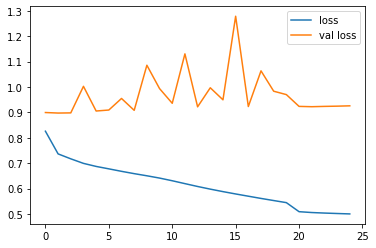

In [14]:
#Shows model performance over the time it is trained. We want to end up with a loss < .6
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [15]:
#Identifies the movies with sufficent ratings (e.g. 5000 or more). Only these movies can be recommended. 
N_RATINGS_THRESHOLD = 5000
movie_stats = pd.pivot_table(df, values = "rating", index = ["title","new_movie_id"], 
                aggfunc=[np.mean, np.count_nonzero]).reset_index()
movie_stats.columns = ['title','new_movie_id','mean_rating','n_ratings']
df_movies_with_sufficent_ratings = movie_stats.loc[movie_stats['n_ratings'] >= N_RATINGS_THRESHOLD]
df_ratings_sufficent_movies_only = df_movies_with_sufficent_ratings.merge(df)
possible_rec_movies_ids = set(df_ratings_sufficent_movies_only['new_movie_id'].values)

In [16]:
#method to predict ratings for a user. Movies must be unwatched and have a sufficent number of ratings
def predict_ratings(user_id):
    watched_movies = df_ratings_sufficent_movies_only.loc[df_ratings_sufficent_movies_only['userId'] == user_id]
    watched_movie_ids_any = set(watched_movies['new_movie_id'].values)
    unwatched_movie_ids_possible = possible_rec_movies_ids - watched_movie_ids_any
    user_id_array = np.array([user_id for i in range(len(unwatched_movie_ids_possible))])
    unwatched_movie_ids_possible_array = np.array(list(unwatched_movie_ids_possible))
    predicted_ratings = model.predict([user_id_array, unwatched_movie_ids_possible_array]).flatten()
    predicted_ratings_uncentered = [i + mRatings for i in predicted_ratings]
    list_ids_and_prediction = list(zip(list(unwatched_movie_ids_possible_array),list(predicted_ratings_uncentered)))
    df_ids_and_prediction = pd.DataFrame(list_ids_and_prediction, columns = ['new_movie_id', 'predicted_rating_uncentered'])
    return df_ids_and_prediction

In [17]:
#Before running predictions on the hidden data check how many users and ratings are applicable
users_with_hidden_data = list(set(df_test_hide_hidden['new_user_id'].values))
print(str(len(users_with_hidden_data)) + " users have " + str(len(df_test_hide_hidden)) + " ratings hidden from the model")

2770 users have 383397 ratings hidden from the model


In [18]:
#For every user with hidden data, make predictions for every unwatched, sufficently-rated movie
#Track the data in single tall dataframe
users_with_hidden_data =list(set(df_test_hide_hidden['new_user_id'].values))
predictions_for_hidden_data = pd.DataFrame()
for user_id in users_with_hidden_data:
    predicted_ratings = predict_ratings(user_id)
    predicted_ratings['user_id'] = user_id
    if predictions_for_hidden_data.empty == True:
        predictions_for_hidden_data = predicted_ratings
    else:
        predictions_for_hidden_data = predictions_for_hidden_data.append(predicted_ratings, ignore_index = True)

30/30 [==============================] - 0s 759us/step


In [64]:
#merge the hidden ratings (that the model never "saw") to the same table as the predicted ratings by the model
df_test_hide_hidden=df_test_hide_hidden.rename(columns={'new_user_id':'user_id'})
df_prediction_eval = predictions_for_hidden_data.merge(df_test_hide_hidden)
df_prediction_eval = df_prediction_eval[['rating','new_movie_id','predicted_rating_uncentered','user_id','mean_rating','n_ratings']]

In [92]:
#Create a "hybrid" prediction model that prevents the Neural Network from going too far from the movie_mean
MAX_DEVIATION = 0.7
df_prediction_eval['diff_NN_predict_and_movie_mean'] = abs(df_prediction_eval['predicted_rating_uncentered'] 
        - df_prediction_eval ['mean_rating'])
df_prediction_eval['NN_predict_minus_mean_rating'] = (df_prediction_eval['predicted_rating_uncentered'] 
        - df_prediction_eval ['mean_rating'])
conditions = [
    (df_prediction_eval['diff_NN_predict_and_movie_mean'] > MAX_DEVIATION),
    (df_prediction_eval['diff_NN_predict_and_movie_mean'] < -MAX_DEVIATION),
    True
    ]

values = [df_prediction_eval['mean_rating'] + MAX_DEVIATION,
            df_prediction_eval['mean_rating'] - MAX_DEVIATION,
            df_prediction_eval['predicted_rating_uncentered']
            ]

df_prediction_eval['hybrid_prediction'] = np.select(conditions, values)

In [93]:
# Our first control model is assigning random predicted ratings to each movie
# We want to assign random ratings with a mean and standard deviation the same as the overall dataset of 20 million ratings
# So we calcualte random values between 0 and 1 and use the normal curve to convert these to standard scores then rating values
control1_random_ratings = []
for i in range(len(df_prediction_eval)):
    std_score = st.norm.ppf(random.random())
    rating = mRatings + (std_score * stdRatings)
    control1_random_ratings.append(rating)
df_prediction_eval["control1_predicted_rating"] = control1_random_ratings

In [94]:
#Unit test to confirm the random ratings mean and std for control 1 are close to that of the whole sample
array_control1_random_ratings = np.array(control1_random_ratings)
assert 0.1 > abs(array_control1_random_ratings.mean() - mRatings), "mean of control1 is not close to sample mean"
assert 0.1 > abs(array_control1_random_ratings.std() - stdRatings), "std of control1 is not close to sample std"

In [95]:
#Control 2 gives each user/movie a predicted rating equal to the mean rating for that movie in the whole sample
df_prediction_eval['control2_predicted_rating'] = df_prediction_eval['mean_rating']
df_prediction_eval = df_prediction_eval.rename(columns={'rating':'actual_hidden_rating'})


In [96]:
#Standardize each prediction and the real hidden rating and caclcuale mean squared error
df_prediction_eval['zscore_actual'] = (df_prediction_eval['actual_hidden_rating'] - mRatings) / stdRatings
df_prediction_eval['zscore_control1'] = (df_prediction_eval['control1_predicted_rating'] - mRatings) / stdRatings
df_prediction_eval['zscore_control2'] = (df_prediction_eval['control2_predicted_rating'] - mRatings) / stdRatings
df_prediction_eval['zscore_prediction'] = (df_prediction_eval['predicted_rating_uncentered'] - mRatings) / stdRatings
df_prediction_eval['zscore_hybrid'] = (df_prediction_eval['hybrid_prediction'] - mRatings) / stdRatings
df_prediction_eval['control1_sq_error'] = (df_prediction_eval['zscore_actual'] - df_prediction_eval['zscore_control1']) ** 2
df_prediction_eval['control2_sq_error'] = (df_prediction_eval['zscore_actual'] - df_prediction_eval['zscore_control2']) ** 2
df_prediction_eval['prediction_sq_error'] = (df_prediction_eval['zscore_actual'] - df_prediction_eval['zscore_prediction']) ** 2
df_prediction_eval['hybrid_sq_error'] = (df_prediction_eval['zscore_actual'] - df_prediction_eval['zscore_hybrid']) ** 2
msq_control1 = df_prediction_eval['control1_sq_error'].mean()
msq_control2 = df_prediction_eval['control2_sq_error'].mean()
msq_NN_model = df_prediction_eval['prediction_sq_error'].mean()
msq_hybrid_model = df_prediction_eval['hybrid_sq_error'].mean()



In [97]:
#Calcualte Pearson correlation between each model and the actual hidden ratings
correl_control1 = df_prediction_eval['actual_hidden_rating'].corr(df_prediction_eval['control1_predicted_rating'])
correl_control2 = df_prediction_eval['actual_hidden_rating'].corr(df_prediction_eval['control2_predicted_rating'])
correl_NN_predict = df_prediction_eval['actual_hidden_rating'].corr(df_prediction_eval['predicted_rating_uncentered'])
correl_hybrid = df_prediction_eval['actual_hidden_rating'].corr(df_prediction_eval['predicted_rating_uncentered'])

In [98]:
#Display results of analysis
summary_results = [    ['control 1 - random ratings' ,msq_control1, correl_control1],
            ['control 2 - samplewide movie mean', msq_control2, correl_control2],
            ['neural network prediction', msq_NN_model, correl_NN_predict],
            ['hybrid', msq_hybrid_model, correl_hybrid]]
summary_results = pd.DataFrame(summary_results, columns = ['Model', 'Mean Squared Error','Pearson Correlation'])
summary_results

,Model,Mean Squared Error,Pearson Correlation
0,control 1 - random ratings,1.948917,-0.000702
1,control 2 - samplewide movie mean,0.800659,0.396171
2,neural network prediction,0.836182,0.354202
3,hybrid,0.836232,0.354202


In [99]:
#OLS Linear regression to see how to best predict actual ratings
x = df_prediction_eval[['mean_rating','predicted_rating_uncentered','n_ratings']]
y = df_prediction_eval['actual_hidden_rating']
x = sm.add_constant(x)
regression = sm.OLS(y, x).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     actual_hidden_rating   R-squared:                       0.157
Model:                              OLS   Adj. R-squared:                  0.157
Method:                   Least Squares   F-statistic:                 1.292e+04
Date:                  Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                          12:46:39   Log-Likelihood:            -2.8272e+05
No. Observations:                208125   AIC:                         5.654e+05
Df Residuals:                    208121   BIC:                         5.655e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0662      0.019     -3.540      0.000      -0.103      -0.030
mean_rating                     1.0011      0.011     88.149      0.000       0.979       1.023
predicted_rating_uncentered     0.0179      0.010      1.717      0.086      -0.003       0.038
n_ratings                   -4.744e-07   2.47e-07     -1.919      0.055   -9.59e-07    1.02e-08
==============================================================================
Omnibus:                    13907.559   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17421.480
Skew:                          -0.639   Prob(JB):                         0.00
Kurtosis:                       3.612   Cond. No.                     1.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
# find top 30 predictions for each user - these are the recommendations
# users with some hidden data are eligible. 
# The recommended movies may or may not be ones with hidden actual ratings.
# Movies that the model "knew" the user has already seen are not eligible. 
predictions_for_hidden_data = predictions_for_hidden_data.sort_values(by=[ 'user_id', 'predicted_rating_uncentered'], ascending=False)
recommended_movies = predictions_for_hidden_data.groupby('user_id').head(30)


In [101]:
#unit test: confirm that each user has 30 movies recommended and 
#that the predicted ratings for them average at least 0.5 standard deviation above the mean (since they are suppsoed to be high)
assert len(recommended_movies) / 30 == len(set(predictions_for_hidden_data['user_id'])), "wrong numebr of movies recommended"
assert recommended_movies['predicted_rating_uncentered'].mean() > mRatings + (0.5 * stdRatings), "ratings too low"


In [103]:
#merge the recommended_movies back with the hidden ratings to see the actual rating of the recommended movies
df_rec_stats = recommended_movies.merge(df_test_hide_hidden)

print(str(len(recommended_movies))+ ' movies were recommended to ' + str(len(set(predictions_for_hidden_data['user_id'])))
    + ' users\n' + str(len(df_rec_stats)) + ' of these had ratings that were hidden from the model\n' + 'The mean of these ratings is ' +
    str(df_rec_stats['rating'].mean()) + ' with standard deviation of ' + str(df_rec_stats['rating'].std()))

83100 movies were recommended to 2770 users
8838 of these had ratings that were hidden from the model
The mean of these ratings is 4.142453043675039 with standard deviation of 0.8459578196157883


In [42]:
df_prediction_eval

,actual_hidden_rating,new_movie_id,predicted_rating_uncentered,user_id,mean_rating,n_ratings,control1_predicted_rating,control2_predicted_rating,zscore_actual,zscore_control1,zscore_control2,zscore_prediction,control1_sq_error,control2_sq_error,prediction_sq_error
0,4.5,8267,3.970474,114688,3.825197,5326,2.133669,3.825197,0.926313,-1.323074,0.284859,0.422957,5.059745,0.411464,0.253368
1,4.5,8274,3.563234,114688,3.466994,5499,2.388232,3.466994,0.926313,-1.081092,-0.055642,0.035842,4.029675,0.964236,0.792940
2,4.5,6260,3.651059,114688,3.296389,17003,2.927282,3.296389,0.926313,-0.568681,-0.217816,0.119326,2.235009,1.309031,0.651228
3,4.5,2239,4.510654,114688,4.175837,18156,3.974604,4.175837,0.926313,0.426882,0.618171,0.936441,0.249432,0.094952,0.000103
4,4.0,2244,4.359134,114688,4.151208,23309,5.610286,4.151208,0.451023,1.981730,0.594758,0.792409,2.343063,0.020660,0.116544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208120,5.0,3917,4.053554,106495,4.042147,17617,4.212207,4.042147,1.401604,0.652743,0.491087,0.501930,0.560791,0.829040,0.809412
208121,5.0,12201,3.840737,106495,3.825420,5055,3.960059,3.825420,1.401604,0.413056,0.285071,0.299631,0.977225,1.246644,1.214343
208122,4.5,14262,4.058244,106495,3.849880,5429,3.826624,3.849880,0.926313,0.286216,0.308322,0.506389,0.409725,0.381913,0.176337
208123,5.0,6089,3.414133,106495,3.633017,5488,4.745359,3.633017,1.401604,1.159547,0.102177,-0.105890,0.058591,1.688510,2.272538


In [49]:
df_prediction_eval['diff_NN_predict_and_movie_mean'] = abs(df_prediction_eval['predicted_rating_uncentered'] 
        - df_prediction_eval ['mean_rating'])
df_prediction_eval['NN_predict_minus_mean_rating'] = (df_prediction_eval['predicted_rating_uncentered'] 
        - df_prediction_eval ['mean_rating'])
conditions = [
    (df_prediction_eval['diff_NN_predict_and_movie_mean'] > 0.228692),
    (df_prediction_eval['diff_NN_predict_and_movie_mean'] < -0.228692),
    True
    ]

values = [df_prediction_eval['mean_rating'] + 0.228692,
            df_prediction_eval['mean_rating'] - 0.228692,
            df_prediction_eval['predicted_rating_uncentered']
            ]

df_prediction_eval['Hybrid Prediction'] = np.select(conditions, values)
df_prediction_eval

,actual_hidden_rating,new_movie_id,predicted_rating_uncentered,user_id,mean_rating,n_ratings,control1_predicted_rating,control2_predicted_rating,zscore_actual,zscore_control1,zscore_control2,zscore_prediction,control1_sq_error,control2_sq_error,prediction_sq_error,diff_NN_predict_and_movie_mean,NN_predict_minus_mean_rating
count,208125.000000,208125.000000,208125.000000,208125.000000,208125.000000,208125.000000,208125.000000,208125.000000,208125.000000,208125.000000,208125.000000,208125.000000,2.081250e+05,2.081250e+05,2.081250e+05,208125.000000,208125.000000
mean,3.584019,2644.934972,3.615512,70019.556565,3.588985,15298.786936,3.526260,3.588985,0.055600,0.000695,0.060320,0.085536,1.940928e+00,8.006594e-01,8.361821e-01,0.159268,0.026527
std,1.025165,2896.633190,0.435840,40551.435340,0.399691,8575.237249,1.050815,0.399691,0.974501,0.998884,0.379939,0.414301,2.763776e+00,1.295875e+00,1.359777e+00,0.121898,0.198801
min,0.500000,1.000000,1.516045,4.000000,1.912317,5005.000000,-1.554954,1.912317,-2.876008,-4.829407,-1.533487,-1.910175,2.109578e-12,3.124955e-08,1.587474e-12,0.000002,-1.072506
25%,3.000000,815.000000,3.344630,34855.000000,3.331509,8252.000000,2.822042,3.331509,-0.499557,-0.668721,-0.184431,-0.171959,1.961073e-01,6.729709e-02,7.023603e-02,0.063347,-0.099878
50%,4.000000,1633.000000,3.666505,71432.000000,3.651107,12901.000000,3.525929,3.651107,0.451023,0.000381,0.119372,0.134010,8.809598e-01,3.283744e-01,3.366803e-01,0.134074,0.034477
75%,4.000000,3320.000000,3.936081,105342.000000,3.885520,20804.000000,4.234263,3.885520,0.451023,0.673709,0.342200,0.390263,2.557374e+00,9.754819e-01,1.005365e+00,0.228692,0.161000
max,5.000000,16166.000000,4.978839,138462.000000,4.275641,40106.000000,8.296577,4.275641,1.401604,4.535265,0.713042,1.381488,3.793122e+01,1.288128e+01,1.596456e+01,1.072506,0.852747
